In [1]:
import os
os.chdir(os.path.expanduser('~/FFF/'))
import fff
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import os
import pickle as pkl
import umap
matplotlib.rcParams.update({'font.size': 18})
import gc         # garbage collect library

INFO: Using pytorch backend
/tmp/ipykernel_1498178/3564497149.py:8: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [4]:
classifier = False

In [15]:
df_class = pd.read_pickle("data/EMnist_Class")

df = pd.read_pickle("data/16EMnist_F5F")
# read targets and conditions from dataframe
test_data, test_targets = (
    torch.from_numpy(df["test_x"]),
    torch.from_numpy(df["test_y"]),
)

train_l, test_l = (
    torch.from_numpy(df_class["train_l"]),
    torch.from_numpy(df_class["test_l"]),
)
test_l = torch.argmax(test_l, dim=1)

In [10]:
if classifier:
    GT = fff.FreeFormInjectiveFlow.load_from_checkpoint(
        "lightning_logs/classifier/version_4/checkpoints/last.ckpt"
    )
else:
    GT_src = "GTs/16EMnist_F5F"
    GT = fff.FreeFormInjectiveFlow.load_from_checkpoint(
    #"GTs/16Mnist_F3F/checkpoints/best.ckpt"
    #"GTs/16Mnist_F5F_4/checkpoints/last.ckpt"
    f"{GT_src}/checkpoints/last.ckpt"
    )
GT.eval()

torch.Size([240000, 1, 16, 16])
cond_dim:  0
latent_dim:  5
[100, 32, 32, 100]
[100, 32, 32, 100]
[100, 32, 32, 100]
[100, 32, 32, 100]


FreeFormInjectiveFlow(
  (models): Sequential(
    (0): ConvolutionalNeuralNetwork(
      (model): Sequential(
        (encoder): Sequential(
          (0): Unflatten(dim=-1, unflattened_size=(1, 16, 16))
          (1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
          (2): ReLU()
          (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
          (4): ReLU()
          (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
          (6): ReLU()
          (7): Flatten(start_dim=-3, end_dim=-1)
          (8): Linear(in_features=1024, out_features=100, bias=True)
        )
        (decoder): Sequential(
          (0): Linear(in_features=100, out_features=4096, bias=True)
          (1): Unflatten(dim=-1, unflattened_size=(256, 4, 4))
          (2): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
          (3): ReLU()
          (4): ConvTranspose2d(128, 1, kernel_size=(3, 3), stride=(2, 2), paddi

In [7]:
if classifier:
    model = fff.FreeFormInjectiveFlow.load_from_checkpoint(
        "lightning_logs/F5F_4/version_0/checkpoints/last.ckpt"
    )
else:
    model = fff.FreeFormInjectiveFlow.load_from_checkpoint(
        "lightning_logs/F5F_4/version_0/checkpoints/last.ckpt"
    )

torch.Size([240000, 1, 16, 16])
cond_dim:  0
latent_dim:  3
[100, 32, 32, 100]
[100, 32, 32, 100]
[100, 32, 32, 100]
[100, 32, 32, 100]


In [8]:
torch.set_grad_enabled(False)

torch.Size([4000, 256])
torch.Size([942, 256])
tensor([], dtype=torch.bool)
encoding...
reconstructing...
encoding...
reconstructing...
sampling...


IndexError: index 3 is out of bounds for dimension 1 with size 3

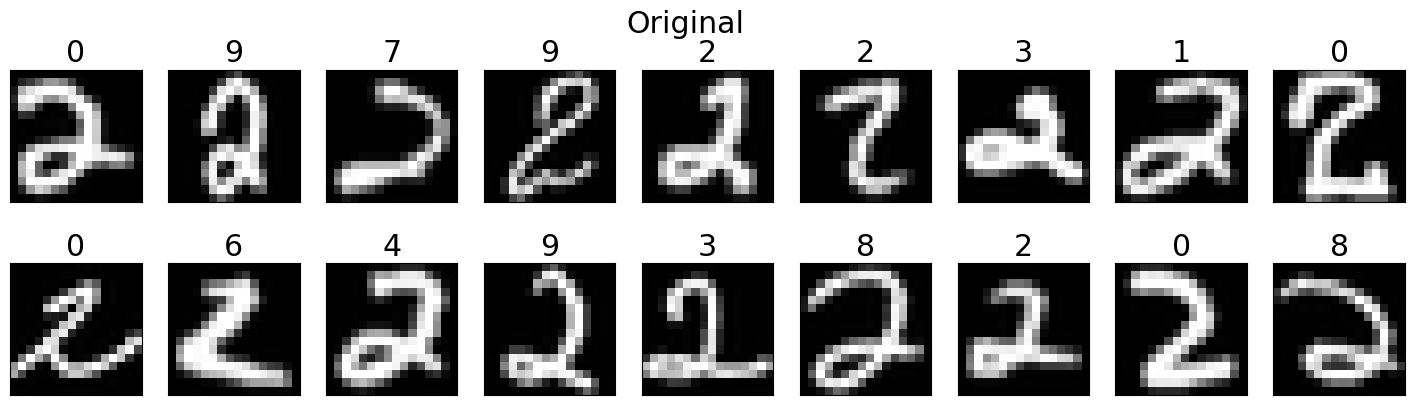

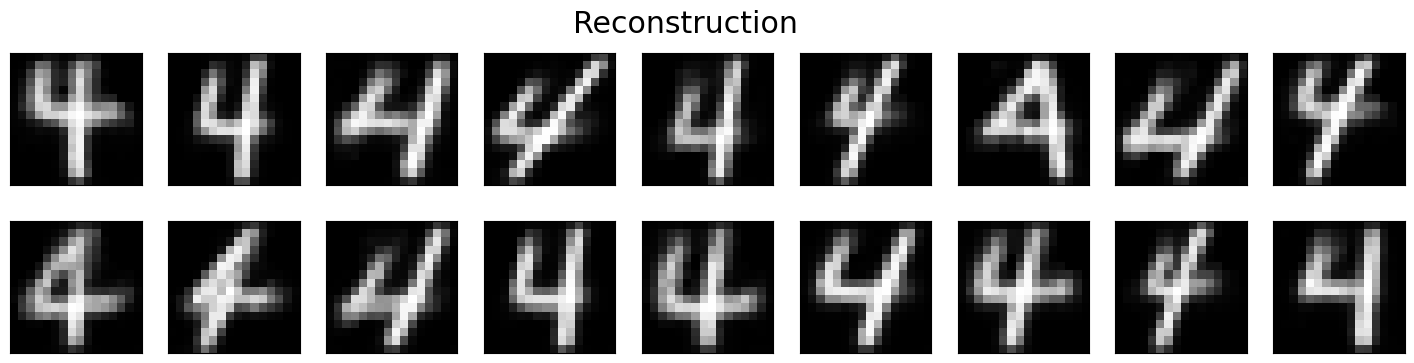

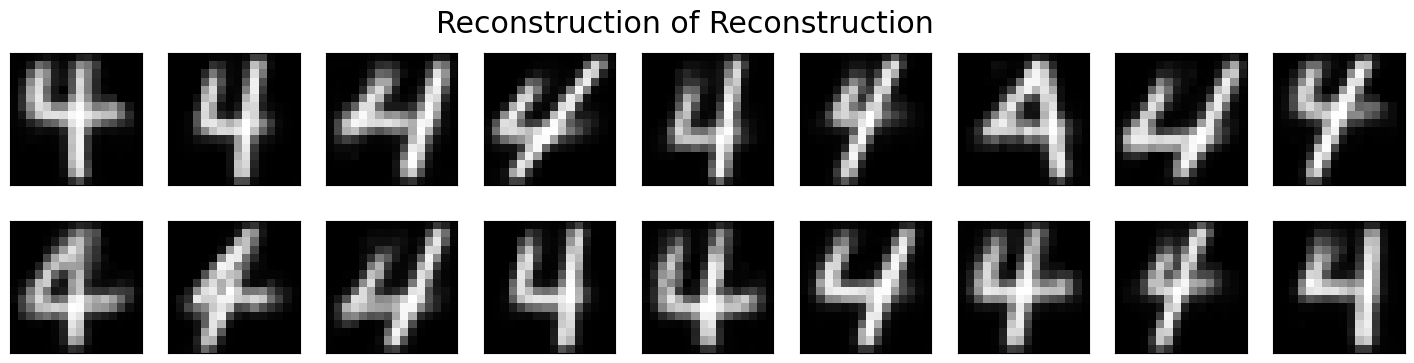

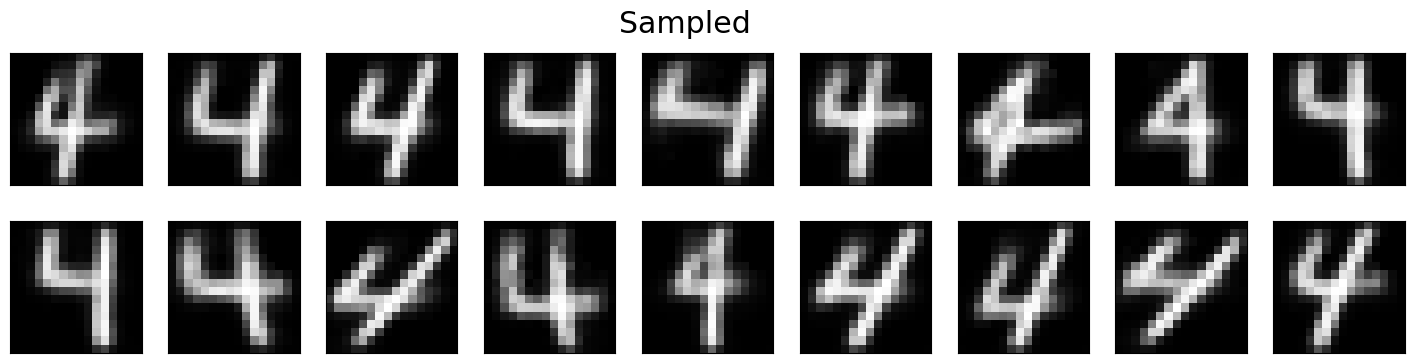

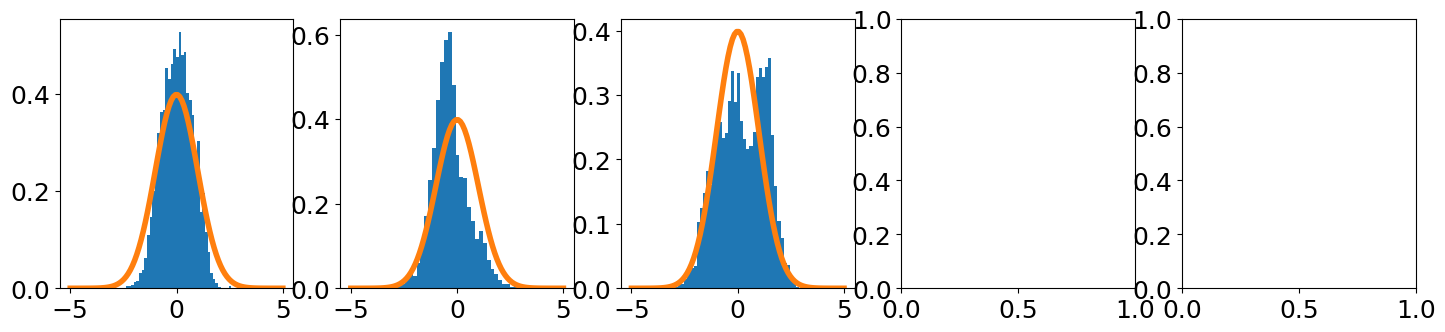

In [21]:
save = False
plot_dir = "emnist/GTs/F5F_4"
from pathlib import Path
import shutil
if save:
    Path(f"plots/{plot_dir}/runfile").mkdir(parents=True, exist_ok=True)
    shutil.copytree(GT_src, f"plots/{plot_dir}/runfile", symlinks=False, ignore=None,ignore_dangling_symlinks=False, dirs_exist_ok=True)
data = plot_mnist(model)
z_test = data["test_z"]
z_dim = z_test.shape[1]
std_z0 = torch.std(z_test[:,0])
std_z1 = torch.std(z_test[:,1])
print("main detail standard deviation: ", std_z0)
print("2nd detail standard deviation: ", std_z1)
#latent_dim = data["test_c"].shape[1]

In [15]:
zrange = 3*std_z0
matplotlib.rcParams.update({'font.size': 15})
nums = [7,2,1,0,4,1,4,9,5,9,0,6,9,0,1,5,9,7,3,4,0,0,0,0,0,0,0,0,0,0,0,0]

for j in range(1):
    plot_details(model, data, j, zrange)

NameError: name 'std_z0' is not defined

In [20]:
from fff.evaluate.plots import all_conditions
def plot_mnist(model2plt):
    device = model2plt.device
    
    data = {}
    train_batch = model2plt.train_data[:]
    val_batch = model2plt.val_data[:]
    #test_batch = model2plt.test_data[:]
    test_batch = (test_data[test_l==2],)
    print(test_batch[0].size())

    train_conditioned = model2plt.apply_conditions(train_batch)
    train_samples = train_conditioned.x_noisy
    train_c = train_conditioned.condition

    """
    Gen_samples = pd.read_pickle("data/MNIST/mnist16")
    Gen_samples = (Gen_samples - torch.mean(Gen_samples)) / torch.std(Gen_samples)
    #Gen_samples = Gen_samples * torch.std(train_samples) + torch.mean(train_samples)
    Gen_samples = Gen_samples * 0.3081 + 0.1307
    rand_perm = torch.randperm(Gen_samples.shape[0])
    Gen_samples = Gen_samples.reshape(-1,256)
    """
    
    test_conditioned = model2plt.apply_conditions(test_batch)
    test_c = test_conditioned.condition
    test_samples = test_conditioned.x0
    #test_samples = Gen_samples[rand_perm][:10000]
    #test_samples = test_samples

    first_val_sample = val_batch[0][0]
    print(val_batch[0].shape)
    matches = torch.all(train_batch[0] == first_val_sample, dim=1)
    print(matches[matches==True])
    is_in_train_set = torch.any(matches).item()
    if is_in_train_set:
        print("Warning: val datasets are corrupted!")
    first_val_sample = test_batch[0][0]
    matches = torch.all(train_batch[0] == first_val_sample, dim=1)
    is_in_train_set = torch.any(matches).item()
    if is_in_train_set:
        print("Warning: test datasets are corrupted!")

    batch_size = model2plt.hparams.batch_size
    """
    test_c_GT = torch.cat([
        GT.encode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(test_samples.split(batch_size), test_c.split(batch_size))
    ])
    train_c_GT = torch.cat([
        GT.encode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(train_samples.split(batch_size), train_c.split(batch_size))
    ])
    
    data["test_samples"] = test_samples
    data["train_samples"] = train_samples
    #data["test_c"] = (test_c_GT - center) / std
    #data["train_c"] = (train_c_GT - center) / std
    """
    #computing...
    print("encoding...")
    test_z = torch.cat([
        model2plt.encode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(test_samples.split(batch_size), test_c.split(batch_size))
    ])
    data["test_z"] = test_z.clone()

    """
    #z_san = test_z[:100] + torch.randn_like(test_z[:100]) * 0.4
    add = torch.zeros_like(test_z[:100])
    mins = torch.argmin(torch.abs(test_z[:100]), dim=1)
    inds = torch.stack([torch.Tensor(range(100)).unsqueeze(1), mins.unsqueeze(1)]).int()
    print(inds.dtype)
    add[inds] = 0.5
    z_san = test_z[:100] + add
    
    x_san = model2plt.decode(z_san.to(device), test_c0[:100].to(device))
    conditioned = GT.apply_conditions((x_san[:10],))
    c_emp = conditioned.condition
    x_san = conditioned.x0
    c_san = (GT.encode(x_san.to(GT.device), c_emp.to(GT.device)).detach().cpu()-center)/std
    """
    
    print("reconstructing...")
    reconstruction = torch.cat([
        model2plt.decode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(test_z.split(batch_size), test_c.split(batch_size))
    ])
    print("encoding...")
    test_z_1 = torch.cat([
        model2plt.encode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(reconstruction.split(batch_size), test_c.split(batch_size))
    ])
    print("reconstructing...")
    reconstruction1 = torch.cat([
        model2plt.decode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(test_z_1.split(batch_size), test_c.split(batch_size))
    ])
   
    print("sampling...")
    #x_sampled = model2plt.sample((test_z[:100].shape[0],))
    z_sampled = torch.randn_like(test_z) * 0.9
    x_sampled = torch.cat([
        model2plt.decode(batch.to(device), c_batch.to(device)).detach().cpu()
        for batch, c_batch in zip(z_sampled.split(batch_size), test_c.split(batch_size))
    ])
    
    nrows = 2
    fig, axes = plt.subplots(nrows=nrows, ncols=9, figsize=(18, nrows*2.2+0.2))
    fig.suptitle("Original")
    for i in range(nrows):
        for j in range(9):
            axes[i][j].imshow((test_samples[i*9 +j]).cpu().reshape(16, 16).T, cmap='gray')
            axes[i][j].set_title(f"{test_l[i*9 +j]}")
            axes[i][j].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
            axes[i][j].tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    if save:
        plt.savefig(f"plots/{plot_dir}/original.png", bbox_inches='tight')

    fig, axes = plt.subplots(nrows=nrows, ncols=9, figsize=(18, nrows*2))
    for i in range(nrows):
        for j in range(9):
            axes[i][j].imshow(reconstruction[i*9 +j].cpu().reshape(16, 16).T, cmap='gray')
            axes[i][j].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
            axes[i][j].tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    fig.suptitle("Reconstruction")
    if save:
        plt.savefig(f"plots/{plot_dir}/reconstruction.png", bbox_inches='tight')
        
    #plotting...
    fig, axes = plt.subplots(nrows=nrows, ncols=9, figsize=(18, nrows*2))
    for i in range(nrows):
        for j in range(9):
            axes[i][j].imshow(reconstruction1[i*9 +j].cpu().reshape(16, 16).T, cmap='gray')
            axes[i][j].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
            axes[i][j].tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    fig.suptitle("Reconstruction of Reconstruction")
    if save:
        plt.savefig(f"plots/{plot_dir}/2xreco.png", bbox_inches='tight')
    
    fig, axes = plt.subplots(nrows=nrows, ncols=9, figsize=(18, nrows*2))
    for i in range(nrows):
        for j in range(9):
            axes[i][j].imshow(x_sampled[i*9 +j].cpu().reshape(16, 16).T, cmap='gray')
            axes[i][j].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
            axes[i][j].tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    fig.suptitle("Sampled")
    if save:
        plt.savefig(f"plots/{plot_dir}/sampled.png", bbox_inches='tight')

    """
    #sanity check
    if classifier:
        conditioned = GT.apply_conditions((test_samples[:10],torch.zeros((10,0),device=device)))
        x_san = conditioned.x0
        c_emp = torch.empty((x_san.shape[0], 0), device=x_san.device, dtype=x_san.dtype)
        c_san = (Features.encode(x_san.to(GT.device), c_emp.to(GT.device)).cpu()-center)/std
    else:
        conditioned = GT.apply_conditions((test_samples[:10],))
        c_emp = conditioned.condition
        x_san = conditioned.x0
        c_san = (GT.encode(x_san.to(GT.device), c_emp.to(GT.device)).cpu()-center)/std
    sanity = torch.sqrt(torch.sum((c_san-test_c[:10])**2, dim=1)).numpy()/5
    print(sanity)
    """
    z_dim = test_z.shape[1]

    n_cols = 5
    nrows = max(z_dim//n_cols,1)
    fig, axes = plt.subplots(nrows=nrows, ncols=n_cols, figsize=(n_cols*3.5, nrows*3.5))
    a = np.linspace(-5,5,100)
    for i in range(nrows):
        if n_cols == 1:
            axes[0].hist(test_z[:,i*n_cols+j], bins=40, label="Samples", density=True)
            axes[0].plot(a, normal(a))
        else:
            for j in range(n_cols):
                if nrows==1:
                    axes[j].hist(test_z[:,i*n_cols+j], bins=40, label="Samples", density=True)
                    axes[j].plot(a, normal(a), linewidth=4)
                else:
                    axes[i][j].hist(test_z[:,i*n_cols+j], bins=40, label="Samples", density=True)
                    axes[i][j].plot(a, normal(a), linewidth=4)
    fig.suptitle("Latent")
    fig.tight_layout()
    if save:
        plt.savefig(f"plots/{plot_dir}/latent.png", bbox_inches='tight')

    return data

In [11]:
def normal(x):
    return np.exp(-x**2/2)/np.sqrt(2*np.pi)

In [76]:
def plot_details(model2plot, data, i_sample, zrange):
    device = model2plot.device
    
    pos_min, pos_max = -zrange, zrange
    c = data["test_c"]
    z = data["test_z"]
    train_c = data["train_c"]
    train_samples = data["train_samples"]
    test_samples = data["test_samples"]
    N = 21
    n = 7
    ddim = z_dim
    x_orig = test_samples[i_sample]

    # calculate x_c_x
    conditioned = GT.apply_conditions((test_samples,))
    c_GT = conditioned.condition
    x_GT = conditioned.x0
    y_GT = GT.encode(x_GT.to(GT.device), c_GT.to(GT.device))
    x_test_GT = GT.decode(y_GT, c_GT.to(GT.device)).detach().cpu()
    xcx = x_test_GT[i_sample]

    # calculate Nearest Neighbours
    verify = c[i_sample]
    NN, similar, NN_suptitle, NN_titles = calc_NNs(i_sample, verify, train_c, train_samples, n+1)
    
    #calculate walk along 0th detail dimension with sampled rest
    z0_range = torch.linspace(pos_min, pos_max, N)
    z0_sample = z[i_sample][0].numpy()

    new_details_norm = torch.randn(40,N,ddim-1)*0.8
    z0_range_norm = torch.unsqueeze(z0_range,0)
    z0_range_norm = z0_range_norm.repeat(40,1)
    new_details_norm = torch.cat([torch.unsqueeze(z0_range_norm,2), new_details_norm], dim=2)
    new_details_norm = torch.reshape(new_details_norm, (40*N,ddim))
    vz = new_details_norm
    #print(torch.reshape(new_details_norm, (40,N,100))[0,:,0])
    
    #decoding...
    c_sample = torch.unsqueeze(c[i_sample], dim=0)
    c_sample_norm = c_sample.repeat(40*N,1)
    c_sample_norm0 = torch.empty((c_sample_norm.shape[0], 0), dtype=c_sample.dtype)
    c_sample = c_sample.repeat(N,1)
    
    #vz = torch.randn_like(vz)
    z_orig = model2plot.encode(test_samples[i_sample].to(device), torch.empty(0).to(device))[0].cpu()
    z_orig = z_orig + torch.randn_like(z_orig) * 0.01
    z_orig_rep = z_orig.repeat([40,1])
    #vz = vz.reshape([40,N,-1])
    #vz[:,1,:] = z_orig_rep
    #vz = vz.reshape([40*N,-1])
    vx = model2plot.decode(vz.to(device), c_sample_norm0.to(device)).detach().cpu()
    
    #plotting...
    D_plt_F = {"ind": i_sample, "mark_first": "original", "n": n+1, "save_name": "v_x"}
    i_plot = np.arange(n) * N//n + 1
    D_plt_F["x_plot"] = torch.cat((x_orig.unsqueeze(0), vx[i_plot].detach().cpu()), dim=0)
    #D_plt_F["title_plot = torch.cat((torch.Tensor([z0_sample.item()]), (new_details_norm[i_plot,0]/std_z0)), dim=0)
    D_plt_F["suptitle"] = r"Learned fiber varying main detail [$\sigma$], z_randn"

    # calculate GTs reconstructions
    vxc, D_plt_GT = plot_GT(i_sample, vx, xcx, i_plot, n)

    # calc PGD and plot PGD
    vxpx, res_pgd, D_plt_PGD = plot_PGD(i_sample, vz[i_plot], vx[i_plot], x_orig, c_sample[0], n+1)
    
    # plot GT(x_PGD)
    _, D_plt_PGT = plot_GT(i_sample, vxpx, xcx, range(n), n, name="PGD")

    # plot check fiber
    title_fiber = f"Learned {nums[i_sample]}-fiber check"
    plot_fiber_check(vxc, c_sample, NN, title_fiber, i_plot, res_pgd[:n], N)

    plot_images(**D_plt_F)
    plot_images(**D_plt_GT)
    plot_images(**D_plt_PGD)
    plot_images(**D_plt_PGT)

    # plot NNs
    NN_plot = torch.cat((x_orig.unsqueeze(0), similar), dim=0)
    plot_images(i_sample, NN_plot, titles=NN_titles, suptitle=NN_suptitle, n=n+1, save_name="NNs", mark_first= "original")
    _, D_plt_NN = plot_GT(i_sample, similar, xcx, range(n), n, name="NNs")
    plot_images(**D_plt_NN)

In [2]:
def plot_GT(i_sample, x, x_orig, i_plot, n, name="learned"):
    plot_dict = {"ind": i_sample, "n": n+1, "mark_first": "orig_recon"}
    conditioned = GT.apply_conditions((x,))
    c_GT = conditioned.condition
    x_GT = conditioned.x0
    xc = GT.encode(x_GT.to(GT.device), c_GT.to(GT.device))
    xcx = GT.decode(xc, c_GT.to(GT.device))
    xc = (xc.detach().cpu() - center) / std

    # plotting reconstructions
    plot_dict["x_plot"] = torch.cat((x_orig.detach().cpu().unsqueeze(0), xcx.detach().cpu()[i_plot]), dim=0)
    #x_plot = fiber_rec[i_plot].detach().cpu()
    if name=="learned":
        plot_dict["save_name"] = "v_x_px_x"
        plot_dict["suptitle"] = "Reconstruct learned fiber with base model"
    elif name=="PGD":
        plot_dict["save_name"] = "v_x_c_x"
        plot_dict["suptitle"] = "Reconstruct projected learned fiber with base model"
    elif name=="NNs":
        plot_dict["save_name"] = "NN_c_x"
        plot_dict["suptitle"] = "Reconstruct NNs with base model"
    
    return xc, plot_dict

In [79]:
def plot_PGD(i_sample, z, x, x0, c0, n):
    plot_dict = {"ind": i_sample, "mark_first": "original", "save_name": "v_x_px", "n": n}
    px = []
    res = []
    px.append(x0.unsqueeze(dim=0))
    for zi, xi in zip(z,x):
        pxi, resi = calc_PGD(zi, xi, x0, c0)
        px.append(pxi)
        res.append(resi)

    px = torch.cat(px,dim=0)
    res = torch.cat(res,dim=0).detach().cpu()
    plot_dict["x_plot"] = px
    plot_dict["suptitle"] = "Project learned fiber on true fiber"
    return px[1:], res, plot_dict

In [85]:
def calc_NNs(i_sample, verify, train_c, train_samples, n=8):
    # calculate Nearest Neighbours
    diff = train_c - verify
    diff = torch.sqrt(torch.sum(torch.square(diff), dim =1)/latent_dim)
    ind = torch.argsort(diff)[:n]
    diff = diff[ind]
    #print("squared distance between chosen sample and nearest train samples:", squared_diff[ind]/5)
    similar = train_samples[ind]
    NN = diff[0].numpy()

    # plot NNs
    suptitle = r"Nearest Neighbours in data with distance $\sqrt{\frac{(c_{orig}-c_i)^2}{dim_c}}$"
    titles = np.round(diff.numpy(),2)
    #plot_images(i_sample, similar, titles=titles, suptitle=suptitle)
    
    #dist = torch.sqrt(torch.sum((similar[:-1]-similar[1:])**2,-1))
    #print(dist)
    return NN, similar, suptitle, titles

In [84]:
def plot_images(ind, x_plot, n=8, titles=None, suptitle=None, mark_first=False, save_name=None):
    fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(18, 3))
    for i in range(n):
        axes[i].imshow(x_plot[i].detach().cpu().reshape(16, 16), cmap='gray', vmin=0, vmax=1)
        axes[i].xaxis.set_tick_params(labelbottom=False)
        axes[i].yaxis.set_tick_params(labelleft=False)
        axes[i].set_xticks([])
        axes[i].set_yticks([])
        if isinstance(titles, np.ndarray):
            axes[i].set_title(titles[i])
        elif titles != None:
            axes[i].set_title(titles[i])
    if mark_first:
        for spine in axes[0].spines.values():
            spine.set_edgecolor('red')
            spine.set_linewidth(2)
        axes[0].set_title(mark_first)
    if suptitle != None:
        fig.suptitle(suptitle)
    if save:
        plt.savefig(f"plots/{plot_dir}/{nums[ind]}{save_name}.png", bbox_inches='tight')

In [6]:
def plot_fiber_check(check_fiber, c_sample, NN, title, i_plot, delta2, N):
    delta_coarse = torch.sqrt(torch.sum((check_fiber-c_sample.repeat(40,1))**2, dim=1))/latent_dim
    delta_c_std, delta_c = torch.std_mean(delta_coarse.reshape(40,-1), dim=0)
    delta_c = delta_c.numpy()
    delta_details = np.linspace(-zrange,zrange,N)/std_z0
    
    #plotting...
    plt.figure(figsize=[10,5])
    plt.errorbar(delta_details,delta_c,yerr=delta_c_std, label="average deviation",capsize=5)
    plt.plot(delta_details[i_plot],delta_coarse[i_plot], marker='o', label="images", linestyle='')
    plt.plot(delta_details[i_plot],delta2, marker='o', label="pgd_images", linestyle='')
    
    plt.axhline(y=NN, xmin=-10, xmax=10, color='gray', linestyle="--", label='nearest train sample')
    plt.title(title)
    #plt.title(f"Learned {nums[j]}-fiber at {z_name[i]}")
    plt.ylabel(r"$\frac{|c_{true}-c_{rec}|_2}{dim_c}$", fontsize=22)
    plt.legend(loc="upper center")
    plt.xlabel(r"Main detail input [$\sigma$]")
    plt.ylim((0,4*NN))
    plt.xlim((-zrange/std_z0,zrange/std_z0))
    plt.grid()
    if save:
        plt.savefig(f"plots/{plot_dir}/fiber0/{nums[j]}deviation_{z_name[i]}.png", bbox_inches='tight')

In [81]:
def calc_PGD(z, x, x0, c0):
    torch.set_grad_enabled(True)
    z = torch.unsqueeze(z,dim=0)
    constraint = torch.sqrt(torch.sum(((x0 - x)**2), dim=-1))
    #print("distance: x_original - x_fiber: ", constraint.item())
    c0 = torch.unsqueeze(c0,dim=0)
    
    def closs(c0, c_hat, x_hat):
        v = torch.sqrt(torch.sum(((c0 - c_hat)**2), dim=-1))/latent_dim
        #distance = torch.sqrt(torch.sum(((x_hat.detach().cpu() - vx[0])**2), dim=-1))
        #r = torch.max(torch.Tensor([0., (distance - constraint).item()]))
        #print("loss:", v.item())
        #if r != 0:
        #    print("penalty:", r.item())
        return v
    
    class ZModel(torch.nn.Module):
        def __init__(self):
            super().__init__()
            self.param = torch.nn.Parameter(z.clone())
    
    zmodel = ZModel()
    optimizer = torch.optim.SGD(zmodel.parameters(), lr=0.4)
    max_z = torch.max(torch.abs(zmodel.param))
    
    c_empty = torch.empty((0,), device=model.device, dtype=x.dtype)
    for i in range(1000):
        zx = model.decode(zmodel.param.to(model.device), c_empty)
        conditioned = GT.apply_conditions((zx,))
        c_GT = conditioned.condition
        x_GT = conditioned.x0
        zxc = (GT.encode(x_GT, c_GT).cpu() - center) / std
        loss = closs(c0, zxc, zx)
        loss.backward()
        optimizer.step()
        # check, if image gets further apart than 
        #check = torch.mean(torch.sqrt(torch.sum(((x0 - zx.cpu())**2), dim=-1)))
        #if check > constraint:
        #    print("too far:")
        #    print(check.item())
        optimizer.zero_grad()

    torch.set_grad_enabled(False)

    max_z_after = torch.max(torch.abs(zmodel.param))
    if max_z_after > 5. and (max_z_after-max_z) > 1.:
        print("warning!, z got an extreme value:", max_z_after)
    zx = model.decode(zmodel.param.to(model.device), c_empty).detach().cpu()
    return zx, loss

In [7]:
zrange = 4*std_z0
matplotlib.rcParams.update({'font.size': 15})
nums = [7,2,1,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
z_name = ["z_original", "z_0", "z_randn"]

for j in range(5):
    xs, c_sample, z0_range, NN, z0_sample = plot_details(model, data, j, zrange)
    for i, xi in enumerate(xs):
        if classifier == False:
            conditioned = GT.apply_conditions((xi,))
            c = conditioned.condition
            x = conditioned.x0
            check_fiber = (GT.encode(x.to(GT.device), c.to(GT.device)).cpu() - center) / std
        else:
            conditioned = GT.apply_conditions((xi,c_sample))
            x = conditioned.x0
            c = torch.empty((x.shape[0], 0), device=x.device, dtype=x.dtype)
            check_fiber = (Features.encode(x.to(GT.device), c.to(GT.device)).cpu() - center) / std
        
        #print(torch.max(check_fiber-c_sample, dim=1)[0])
                
        plt.figure(figsize=[6,5])
        if i == 0:
            delta_coarse = torch.sqrt(torch.sum((check_fiber-c_sample)**2, dim=1)).numpy()/latent_dim
            delta_details = z0_range/std_z0
            plt.axvline(x=z0_sample/std_z0, ymin=0, ymax=2,color='red', label='sample')
            plt.plot(delta_details,delta_coarse, label="average deviation")
        elif i==1:
            delta_coarse = torch.sqrt(torch.sum((check_fiber-c_sample)**2, dim=1)).numpy()/latent_dim
            delta_details = np.linspace(-zrange,zrange,z0_range.shape[0])/std_z0
            plt.plot(delta_details,delta_coarse, label="average deviation")
        else:
            delta_coarse = torch.sqrt(torch.sum((check_fiber-c_sample.repeat(40,1))**2, dim=1))/latent_dim
            delta_c_std, delta_c = torch.std_mean(delta_coarse.reshape(40,-1), dim=0)
            delta_c = delta_c.numpy()
            delta_details = np.linspace(-zrange,zrange,z0_range.shape[0])/std_z0
            plt.errorbar(delta_details,delta_c,yerr=delta_c_std, label="average deviation",capsize=5)
        plt.plot(delta_details[1::21//7],delta_coarse[1:21:21//7], marker='o', label="images", linestyle='')
            
        #plotting...
        plt.axhline(y=NN, xmin=-10, xmax=10, color='gray', linestyle="--", label='nearest train sample')
        plt.title(f"Learned {nums[j]}-fiber at {z_name[i]}")
        plt.ylabel(r"$\frac{|c_{true}-c_{rec}|_2}{dim_c}$", fontsize=18)
        plt.legend()
        plt.xlabel(r"Main detail input [$\sigma$]")
        plt.ylim((0,2*NN))
        plt.xlim((-zrange/std_z0,zrange/std_z0))
        plt.grid()
        if save:
            plt.savefig(f"plots/{plot_dir}/fiber0/{nums[j]}deviation_{z_name[i]}.png", bbox_inches='tight')

NameError: name 'std_z0' is not defined

In [8]:
def plot_details(model2plot, data, sample, zrange):
    nums = [7,2,1,0,4]
    device = model2plot.device
    
    pos_min, pos_max = -zrange, zrange
    c = data["test_c"]
    z = data["test_z"]
    train_c = data["train_c"]
    train_samples = data["train_samples"]
    N = 21
    n = 7
    ddim = 64

    #calculate two walks along main detail dimension
    z0_range = torch.linspace(pos_min, pos_max, N)
    z0_range1 = z0_range.clone()
    z0_range1[torch.argmin((z0_range-z[sample][0])**2)] = z[sample][0]
    z0_sample = z[sample][0].numpy()
    
    z_list = []
    for i in range(N):
        z_new = z[sample].clone()
        z_new[0] = z0_range1[i]
        z_list.append(z_new)
    new_details1 = torch.stack(z_list)

    z_list = []
    for i in range(N):
        z_new = torch.zeros(ddim)
        z_new[2] = z0_range[i]
        z_list.append(z_new)
    new_details0 = torch.stack(z_list)
    #new_details0 = torch.zeros(N,53)
    #new_details0 = torch.cat([torch.unsqueeze(z0_range,1), new_details0], dim=1)
    
    new_details_norm = torch.randn(40,N,ddim-1)*std_z1
    z0_range_norm = torch.unsqueeze(z0_range,0)
    z0_range_norm = z0_range_norm.repeat(40,1)
    new_details_norm = torch.cat([torch.unsqueeze(z0_range_norm,2), new_details_norm], dim=2)
    new_details_norm = torch.reshape(new_details_norm, (40*N,ddim))
    #print(torch.reshape(new_details_norm, (40,N,100))[0,:,0])
    
    #decoding...
    c_sample = torch.unsqueeze(c[sample], dim=0)
    c_sample_norm = c_sample.repeat(40*N,1)
    c_sample = c_sample.repeat(N,1)
    x_details1 = model2plot.decode(new_details1.to(device), c_sample.to(device)).cpu()
    x_details_norm = model2plot.decode(new_details_norm.to(device), c_sample_norm.to(device)).cpu()
    x_details0 = model2plot.decode(new_details0.to(device), c_sample.to(device)).cpu()

    #plotting...
    fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(14, 3))
    del_detail = []
    for i in range(n):
        axes[i].imshow(x_details1[i*N//n+1].cpu().reshape(16, 16), cmap='gray')
        axes[i].set_title((z0_range1[i*N//n+1]/std_z0).numpy().round(1))
        del_detail.append(z0_range1[i*N//n+1])
    del_detail = (np.array(del_detail)-z0_sample)**2
    closest = np.argmin(del_detail)
    for spine in axes[closest].spines.values():
        spine.set_edgecolor('red')
        spine.set_linewidth(2)
    plt.suptitle(r"learned fiber varying main detail [$\sigma$], z_orig")
    if save:
        plt.savefig(f"plots/{plot_dir}/fiber0/{nums[sample]}fiber_zorig.png", bbox_inches='tight')

    fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(14, 3))
    for i in range(n):
        axes[i].imshow(x_details0[i*N//n+1].cpu().reshape(16, 16), cmap='gray')
        axes[i].set_title((z0_range[i*N//n+1]/std_z0).numpy().round(1))
    plt.suptitle(r"learned fiber varying main detail [$\sigma$], z_0")
    if save:
        plt.savefig(f"plots/{plot_dir}/fiber0/{nums[sample]}fiber_z0.png", bbox_inches='tight')
    
    fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(14, 3))
    for i in range(n):
        axes[i].imshow(x_details_norm[i*N//n+1].cpu().reshape(16, 16), cmap='gray')
        axes[i].set_title((new_details_norm[i*N//n+1,0]/std_z0).numpy().round(1))
    plt.suptitle(r"learned fiber varying main detail [$\sigma$], z_randn")
    if save:
        plt.savefig(f"plots/{plot_dir}/fiber0/{nums[sample]}fiber_znew.png", bbox_inches='tight')

    verify = c[sample]
    diff = train_c - verify
    squared_diff = torch.sqrt(torch.sum(torch.square(diff), dim =1))
    ind = torch.argsort(squared_diff)[:n]
    #print("squared distance between chosen sample and nearest train samples:", squared_diff[ind]/5)
    similar = train_samples[ind]
    NN = squared_diff[ind[0]].numpy()/latent_dim

    fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(14, 3))
    for i in range(n):
        axes[i].imshow(similar[i].cpu().reshape(16, 16), cmap='gray')
        axes[i].set_title(np.round(squared_diff[ind[i]].numpy()/latent_dim,2))
    fig.suptitle(r"Nearest Neighbours in data with distance $\frac{|c_{orig}-c_i|_2}{dim_c}$")
    if save:
        plt.savefig(f"plots/{plot_dir}/fiber0/{nums[sample]}NN.png", bbox_inches='tight')
    
    return [x_details1, x_details0, x_details_norm], c_sample, z0_range1, NN, z0_sample

In [10]:
Classifier = fff.FreeFormInjectiveFlow.load_from_checkpoint(
        "lightning_logs/classifier/version_4/checkpoints/last.ckpt"
    )

FileNotFoundError: [Errno 2] No such file or directory: '/export/home/wjoran/FFF/lightning_logs/classifier/version_4/checkpoints/last.ckpt'

In [11]:
z = (torch.from_numpy(df["test_y"]) - center) / std
y = test_l
reducer = umap.UMAP()
embedding = reducer.fit_transform(z)
print(embedding.shape)

(40000, 2)


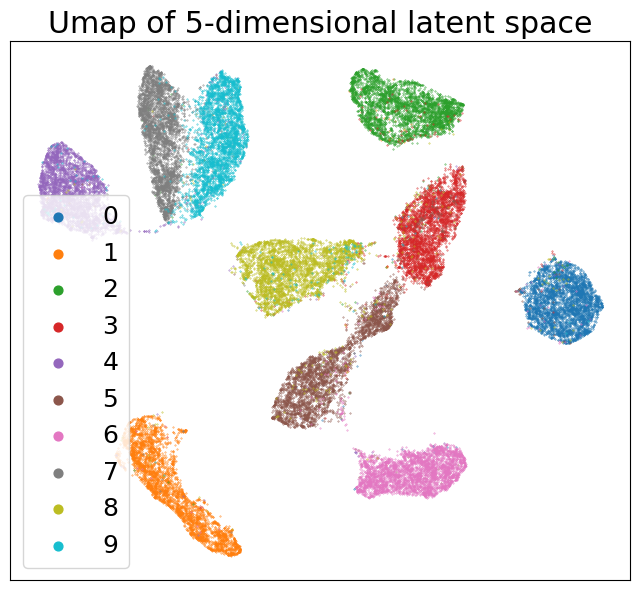

In [13]:
plt.figure(figsize=[8,7])
for i in range(10):
    emb = embedding[y==i]
    plt.scatter(
        emb[:, 0],
        emb[:, 1],
        s=0.1, label=i
    )
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.legend(markerscale=20.,loc='lower left')
plt.title("Umap of 5-dimensional latent space")
plt.savefig(f"plots/emnist/GTs/F5F/umap_latent.png")

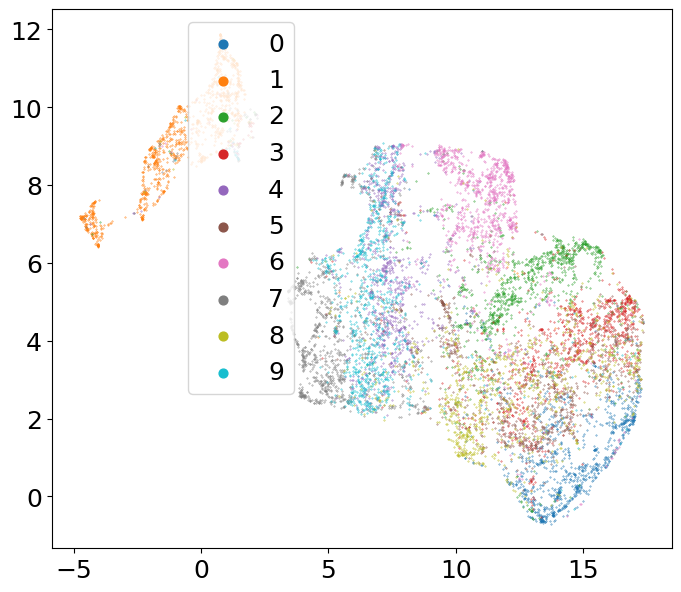

In [19]:
plt.figure(figsize=[8,7])
for i in range(10):
    emb = embedding[y==i]
    plt.scatter(
        emb[:, 0],
        emb[:, 1],
        s=0.1, label=i
    )
plt.legend(markerscale=20.,loc='upper left',bbox_to_anchor=(0.2, 1.))

torch.Size([10000, 10])
torch.Size([10000])


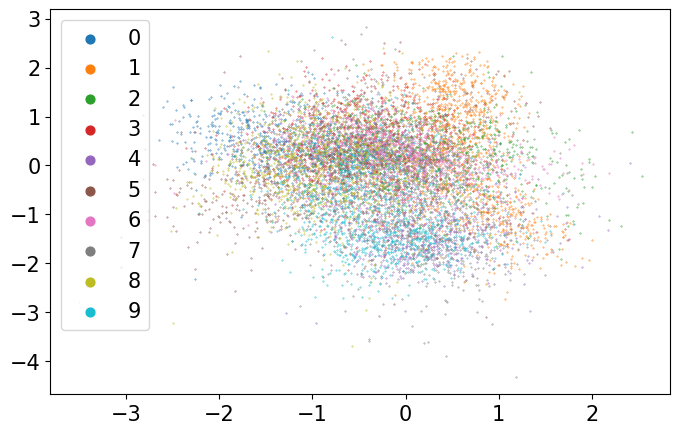

In [30]:
plt.figure(figsize=[8,5])
z = (torch.from_numpy(df["val_y"]) - center) / std
val_data = Classifier.val_data[:]
conditioned = Classifier.apply_conditions(val_data)
t = conditioned.condition
y = np.argmax(t,axis=1)
print(z.shape)
z0 = z[:,6]
z1 = z[:,7]
print(y.shape)
for i in range(10):
    z0i = z0[y==i]
    z1i = z1[y==i]
    plt.scatter(z0i,z1i, s=0.1, label=i)
plt.legend(markerscale=20.)

In [51]:
from fff.model.utils import guess_image_shape
class Truncate(torch.nn.Module):
            def __init__(self):
                super(Truncate, self).__init__()
                enc_conv = list(
                    list(
                    list(
                    list(
                        GT.children()
                    )[1].children()
                    )[0].children()
                    )[0].children()
                    )[0]
                enc_res = list(
                    list(
                    list(
                    list(
                    list(
                        GT.children()
                    )[1].children()
                    )[1].children()
                    )[0].children()
                    )[0].children()
                    )[:-2]
                self.features = torch.nn.Sequential(
                    enc_conv, *enc_res
                )

            def cat_x_c(self, x, c):
                # Reshape as image, and concatenate conditioning as channel dimensions
                has_batch_dimension = len(x.shape) > 1
                if not has_batch_dimension:
                    x = x[None, :]
                    c = c[None, :]
                batch_size = x.shape[0]
                input_shape = guess_image_shape(GT.data_dim)
                x_img = x.reshape(batch_size, *input_shape)
                c_img = c[:, :, None, None] * torch.ones(batch_size, GT.cond_dim, *input_shape[1:], device=c.device)
                out = torch.cat([x_img, c_img], -3).reshape(batch_size, -1)
                if not has_batch_dimension:
                    out = out[0]
                return out
            
            def encode(self, x, c):
                x = self.features(self.cat_x_c(x,c))
                return x

Features = Truncate()

In [23]:
data = save_data(model)

torch.Size([230000, 256])
torch.Size([10000, 256])
torch.Size([230000])
tensor([], dtype=torch.bool)
encoding traindata...
encoding valdata...
encoding testdata...


In [22]:
def save_data(rectangular_flow):
    #train_data = rectangular_flow.train_data[:]
    train_data = (torch.from_numpy(df["train_x"]),)
    """
    Gen_samples = pd.read_pickle("data/MNIST/mnist16")
    Gen_samples = (Gen_samples - torch.mean(Gen_samples)) / torch.std(Gen_samples)
    #Gen_samples = Gen_samples * torch.std(train_samples) + torch.mean(train_samples)
    Gen_samples = Gen_samples * 0.3081 + 0.1307
    rand_perm = torch.randperm(Gen_samples.shape[0])
    Gen_samples = Gen_samples.reshape(-1,256)

    print(train_data[0].shape)
    train_data = torch.cat([train_data[0], Gen_samples[rand_perm]], dim=0)
    train_data = (train_data,)
    """
    print(train_data[0].shape)
    #val_data = rectangular_flow.val_data[:]
    val_data = (torch.from_numpy(df["val_x"]),)
    #test_data = rectangular_flow.test_data[:]
    test_data = (torch.from_numpy(df["test_x"]),)

    first_val_sample = val_data[0][0]
    print(val_data[0].shape)
    matches = torch.all(train_data[0] == first_val_sample, dim=1)
    print(matches.shape)
    print(matches[matches==True])
    is_in_train_set = torch.any(matches).item()
    if is_in_train_set:
        print("Warning: val datasets are corrupted!")
    first_val_sample = test_data[0][0]
    matches = torch.all(train_data[0] == first_val_sample, dim=1)
    is_in_train_set = torch.any(matches).item()
    if is_in_train_set:
        print("Warning: test datasets are corrupted!")
    
    conditioned = rectangular_flow.apply_conditions(train_data)
    train_samples = conditioned.x0
    c_t = conditioned.condition
    
    conditioned = rectangular_flow.apply_conditions(val_data)
    val_samples = conditioned.x0
    c_v = conditioned.condition

    conditioned = rectangular_flow.apply_conditions(test_data)
    test_samples = conditioned.x0
    c_test = conditioned.condition
    
    device = rectangular_flow.device
    print("encoding traindata...")
    batch_size = rectangular_flow.hparams.batch_size
    z_train = torch.cat([
        rectangular_flow.encode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(train_samples.split(batch_size), c_t.split(batch_size))
    ])
    print("encoding valdata...")
    z_val = torch.cat([
        rectangular_flow.encode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(val_samples.split(batch_size), c_v.split(batch_size))
    ])
    print("encoding testdata...")
    z_test = torch.cat([
        rectangular_flow.encode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(test_samples.split(batch_size), c_test.split(batch_size))
    ])

    data = {}
    
    data["train_x"] = train_samples.cpu().numpy()
    data["train_y"] = z_train.cpu().numpy()
    
    data["val_x"] = val_samples.cpu().numpy()
    data["val_y"] = z_val.cpu().numpy()

    data["test_x"] = test_samples.cpu().numpy()
    data["test_y"] = z_test.cpu().numpy()

    
    path = "data/"
    fileName = path + '16EMnist_F3F_4'
    fileObject = open(fileName, 'wb')
    
    pkl.dump(data, fileObject)
    fileObject.close()

In [24]:
from math import log10

def rand_log_uniform(vmin, vmax, shape, device, dtype):
    vmin, vmax = map(log10, [vmin, vmax])
    return torch.rand(
        shape, device=device, dtype=dtype
    ) * (vmin - vmax) + vmax

def save_data(rectangular_flow):
    max_noise = 0.05
    min_noise = 0.01
    train_data = rectangular_flow.train_data[:]
    val_data = rectangular_flow.val_data[:]
    test_data = rectangular_flow.test_data[:]
    
    conditioned = rectangular_flow.apply_conditions(train_data)
    train_x0 = conditioned.x0
    noise_scale = rand_log_uniform(max_noise, min_noise, shape=(train_x0.shape[0],1), device=train_x0.device, dtype=train_x0.dtype)
    train_samples = train_x0 + torch.randn_like(train_x0) * (10 ** noise_scale)
    c_t = conditioned.condition
    
    conditioned = rectangular_flow.apply_conditions(val_data)
    val_x0 = conditioned.x0
    noise_scale = rand_log_uniform(max_noise, min_noise, shape=(val_x0.shape[0],1), device=val_x0.device, dtype=val_x0.dtype)
    val_samples = val_x0 + torch.randn_like(val_x0) * (10 ** noise_scale)
    c_v = conditioned.condition

    conditioned = rectangular_flow.apply_conditions(test_data)
    test_x0 = conditioned.x0
    noise_scale = rand_log_uniform(max_noise, min_noise, shape=(test_x0.shape[0],1), device=test_x0.device, dtype=test_x0.dtype)
    test_samples = test_x0 + torch.randn_like(test_x0) * (10 ** noise_scale)
    c_test = conditioned.condition
    
    device = rectangular_flow.device
    print("encoding traindata...")
    batch_size = rectangular_flow.hparams.batch_size
    z_train = torch.cat([
        rectangular_flow.encode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(train_samples.split(batch_size), c_t.split(batch_size))
    ])
    print("encoding valdata...")
    z_val = torch.cat([
        rectangular_flow.encode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(val_samples.split(batch_size), c_v.split(batch_size))
    ])
    print("encoding testdata...")
    z_test = torch.cat([
        rectangular_flow.encode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(test_samples.split(batch_size), c_test.split(batch_size))
    ])

    data = {}
    
    data["train_x"] = train_samples.cpu().numpy()
    data["train_y"] = z_train.cpu().numpy()
    
    data["val_x"] = val_samples.cpu().numpy()
    data["val_y"] = z_val.cpu().numpy()

    data["test_x"] = test_samples.cpu().numpy()
    data["test_y"] = z_test.cpu().numpy()

    path = "data/"
    fileName = path + '16Mnist_AE'
    fileObject = open(fileName, 'wb')
    
    pkl.dump(data, fileObject)
    fileObject.close()
    
    return data

In [22]:
def save_data(rectangular_flow):
    train_data = rectangular_flow.train_data[:]

    Gen_samples = pd.read_pickle("data/MNIST/mnist16")
    Gen_samples = (Gen_samples - torch.mean(Gen_samples)) / torch.std(Gen_samples)
    #Gen_samples = Gen_samples * torch.std(train_samples) + torch.mean(train_samples)
    Gen_samples = Gen_samples * 0.3081 + 0.1307
    rand_perm = torch.randperm(Gen_samples.shape[0])
    Gen_samples = Gen_samples.reshape(-1,256)
    #test_batch = (Gen_samples[rand_perm][:10000],)

    print(train_data[0].shape)
    train_data = torch.cat([train_data[0], Gen_samples[rand_perm]], dim=0)
    print(train_data.shape)
    train_data = (train_data,)
    val_data = rectangular_flow.val_data[:]
    test_data = rectangular_flow.test_data[:]
    
    conditioned = rectangular_flow.apply_conditions(train_data)
    train_samples = conditioned.x0
    c_t = conditioned.condition
    
    conditioned = rectangular_flow.apply_conditions(val_data)
    val_samples = conditioned.x0
    c_v = conditioned.condition

    conditioned = rectangular_flow.apply_conditions(test_data)
    test_samples = conditioned.x0
    c_test = conditioned.condition

    conditioned = GT.apply_conditions(train_data)
    train_samples_GT = conditioned.x0
    c_t_GT = conditioned.condition
    
    conditioned = GT.apply_conditions(val_data)
    val_samples_GT = conditioned.x0
    c_v_GT = conditioned.condition

    conditioned = GT.apply_conditions(test_data)
    test_samples_GT = conditioned.x0
    c_test_GT = conditioned.condition
    
    device = rectangular_flow.device
    print("encoding traindata...")
    batch_size = rectangular_flow.hparams.batch_size
    print(batch_size)
    
    z_train = torch.cat([
        rectangular_flow.encode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(train_samples.split(batch_size), c_t.split(batch_size))
    ])
    
    y_train = torch.cat([
        GT.encode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(train_samples.split(batch_size), c_t_GT.split(batch_size))
    ])
    print("encoding valdata...")
    z_val = torch.cat([
        rectangular_flow.encode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(val_samples.split(batch_size), c_v.split(batch_size))
    ])
    y_val = torch.cat([
        GT.encode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(val_samples.split(batch_size), c_v_GT.split(batch_size))
    ])
    print("encoding testdata...")
    z_test = torch.cat([
        rectangular_flow.encode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(test_samples.split(batch_size), c_test.split(batch_size))
    ])
    y_test = torch.cat([
        GT.encode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(test_samples.split(batch_size), c_test_GT.split(batch_size))
    ])

    data = {}
    
    data["train_x"] = z_train.cpu().numpy()
    data["train_y"] = y_train.cpu().numpy()
    
    data["val_x"] = z_val.cpu().numpy()
    data["val_y"] = y_val.cpu().numpy()

    data["test_x"] = z_test.cpu().numpy()
    data["test_y"] = y_test.cpu().numpy()

    """
    path = "data/"
    fileName = path + '16Mnist_AE_latent'
    fileObject = open(fileName, 'wb')
    
    pkl.dump(data, fileObject)
    fileObject.close()
    """